# Tile-wise Convolution on GOES-16 NetCDF Images with TaskVine

## Dataset: GOES-16 ABI L1b (Full Disk Radiance)
We use files from the NOAA GOES-16 public S3 bucket:
`s3://noaa-goes16/ABI-L1b-RadF/`

Each file (e.g., `OR_ABI-L1b-RadF-M6C16_G16_...nc`) contains a large **2-D radiance array** (`Rad`)
representing a full-disk satellite scan for one spectral channel (e.g., C16).

Key properties:
- **One `.nc` file = one large 2-D image grid** (typically thousands of pixels per dimension)
- Files are **large** (often 100–300 MB each), so tiling is natural.
- Our manager loads **one file at a time**, decomposes into tiles, and dispatches tile-level convolution
  tasks to remote TaskVine workers.

Outputs:
- One filtered output image (PNG) per input `.nc` file.

# Configuration

In [1]:
from pathlib import Path

WORKFLOW_DIR = Path.cwd().resolve()

# goes16 is a symlink
NC_DIR = WORKFLOW_DIR / "goes16"

# resolve symlink to real location
NC_DIR_REAL = NC_DIR.resolve()

# parent of the real directory
DATA_PARENT = NC_DIR_REAL.parent

# create output next to the real data directory
OUT_DIR = DATA_PARENT / "goes16_output"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("NC_DIR (symlink):      ", NC_DIR)
print("NC_DIR (real):         ", NC_DIR_REAL)
print("Output directory:      ", OUT_DIR)

NC_DIR (symlink):       /groups/dthain/users/mislam5/flo-group-base-dir/floability_instance_r-dconv-nd-cold-1_20260209_031840_389344/workflow/goes16
NC_DIR (real):          /groups/dthain/users/mislam5/flo-data-cache/floability-data-cache/5433a15b5b095b881df5dfbc9555bebfeba78401f2e2501982b02f58df9bbc10/cached_data/goes16
Output directory:       /groups/dthain/users/mislam5/flo-data-cache/floability-data-cache/5433a15b5b095b881df5dfbc9555bebfeba78401f2e2501982b02f58df9bbc10/cached_data/goes16_output


In [2]:
# ---- Processing options ------------------------------------------
TILE_SIZE = 256                 # tile side length
SELECT_KERNEL = "sharpen"        # "sharpen" | "gaussian_blur" | "edge_sobel"

# For visualization / saving: radiance -> 8-bit mapping
# (used only for producing a viewable PNG output)
PCT_LOW  = 2
PCT_HIGH = 98

print("Config:")
print(" TILE_SIZE:", TILE_SIZE)
print(" SELECT_KERNEL:", SELECT_KERNEL)
print(" Save mapping percentiles:", (PCT_LOW, PCT_HIGH))


Config:
 TILE_SIZE: 256
 SELECT_KERNEL: sharpen
 Save mapping percentiles: (2, 98)


# Dependencies

In [3]:
import os
import math
import time
import numpy as np

from PIL import Image
import xarray as xr

import ndcctools.taskvine as vine

# Define kernels

In [4]:
KERNELS = {
    "sharpen": np.array([
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0],
    ], dtype=np.float32),

    "gaussian_blur": (1/16) * np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1],
    ], dtype=np.float32),

    "edge_sobel": np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ], dtype=np.float32),
}

if SELECT_KERNEL not in KERNELS:
    raise ValueError(f"Unknown kernel '{SELECT_KERNEL}'. Options: {list(KERNELS.keys())}")

kernel = KERNELS[SELECT_KERNEL]
print("Kernel selected:", SELECT_KERNEL)
print(kernel)

Kernel selected: sharpen
[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]


# Remote worker function (tile convolution)
    

In [5]:
def apply_convolution(tile_np, kernel_np):
    """
    Convolve a single 2-D tile with a 2-D kernel using im2col × GEMM.
    This function is shipped to remote TaskVine workers.

    tile_np:   float32 array (H, W)
    kernel_np: float32 array (k, k)
    returns:   float32 array (H, W)
    """
    import numpy as np

    try:
        # ---- guard: empty or degenerate tiles --------------------
        if (
            tile_np is None
            or tile_np.size == 0
            or tile_np.shape[0] == 0
            or tile_np.shape[1] == 0
        ):
            return tile_np  # safe no-op

        k = kernel_np.shape[0]
        pad = k // 2

        padded = np.pad(tile_np, pad, mode="reflect")

        H, W = tile_np.shape
        shape = (H, W, k, k)
        strides = (
            padded.strides[0], padded.strides[1],
            padded.strides[0], padded.strides[1],
        )
        patches = np.lib.stride_tricks.as_strided(
            padded, shape=shape, strides=strides, writeable=False
        )

        col = patches.reshape(H * W, -1)
        out_flat = col @ kernel_np.reshape(-1, 1)
        return out_flat.reshape(H, W)

    except Exception:
        # ---- last-resort guardrail: never crash worker ----------
        return None


# TaskVine manager name + ports

In [7]:
manager_name = os.environ.get("VINE_MANAGER_NAME", f"goes-tv-{os.getpid()}")
ports_str = os.environ.get("VINE_MANAGER_PORTS", "9123, 9150")
ports = [int(p.strip()) for p in ports_str.split(",")]

print("Manager name:", manager_name)
print("Ports:", ports)

Manager name: floability-7a393077-d1ef-4ac3-91e0-a1b6cd1524f5
Ports: [9123, 9150]


In [8]:
manager_name = os.environ.get("VINE_MANAGER_NAME", f"goes-tv-{os.getpid()}")
ports_str = os.environ.get("VINE_MANAGER_PORTS", "9123, 9150")
ports = [int(p.strip()) for p in ports_str.split(",")]

print("Manager name:", manager_name)
print("Ports:", ports)

Manager name: floability-7a393077-d1ef-4ac3-91e0-a1b6cd1524f5
Ports: [9123, 9150]


In [9]:
m = vine.Manager(ports, name=manager_name)
print("[manager] Listening on port", m.port)

[manager] Listening on port 9123


# Discover .nc files

In [11]:
nc_files = sorted(
    p for p in NC_DIR.rglob("*.nc")
    if p.is_file() and p.stat().st_size > 0
)

In [15]:
# nc_files = nc_files[0:6]

In [16]:
if not nc_files:
    raise FileNotFoundError(f"No .nc files found in {NC_DIR.resolve()}")

print(f"Found {len(nc_files)} NetCDF files:")

Found 4 NetCDF files:


# Helper: load GOES radiance image

In [17]:
def load_goes_radiance_2d(nc_path: Path) -> np.ndarray:
    """
    Load a GOES-16 ABI L1b Full Disk NetCDF and extract the 2-D radiance array.

    Most ABI-L1b-Rad files include:
      - 'Rad' : 2-D radiance image
      - 'DQF' : quality flags (optional)
    """
    ds = xr.open_dataset(nc_path, engine="netcdf4")

    if "Rad" not in ds:
        raise KeyError(f"{nc_path.name}: variable 'Rad' not found. Variables: {list(ds.data_vars)}")

    rad = ds["Rad"].astype("float32")

    # Convert to NumPy; force load then close file
    img = rad.values

    ds.close()
    return img


# Helper: map float image to 8-bit

In [18]:
def to_uint8_for_png(img_f32: np.ndarray, pct_low=2, pct_high=98) -> np.ndarray:
    """
    Robust visualization mapping:
    - ignores NaNs when computing percentiles
    - replaces NaNs/Infs with 0
    - guarantees safe uint8 casting
    """
    x = img_f32

    # mask invalid values
    finite = np.isfinite(x)
    if not np.any(finite):
        return np.zeros_like(x, dtype=np.uint8)

    lo = np.percentile(x[finite], pct_low)
    hi = np.percentile(x[finite], pct_high)

    if hi <= lo:
        return np.zeros_like(x, dtype=np.uint8)

    y = (x - lo) / (hi - lo)

    # clip and sanitize
    y = np.clip(y, 0.0, 1.0)
    y = np.nan_to_num(y, nan=0.0, posinf=1.0, neginf=0.0)

    return (y * 255.0).astype(np.uint8)


Sample: OR_ABI-L1b-RadF-M6C01_G16_s20242000000213_e20242000009521_c20242000009557.nc
Shape: (10848, 10848) dtype: float32
Min/Max: -1.573455810546875 804.0360717773438


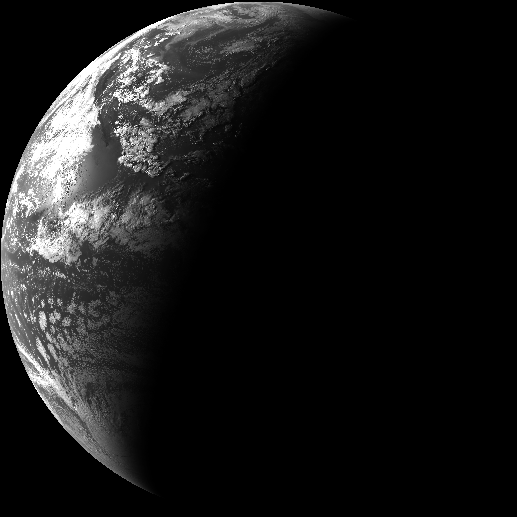

In [19]:

# ---- lightweight preview (stride-based) ---------------------------
sample_path = nc_files[0]
img = load_goes_radiance_2d(sample_path)

print("Sample:", sample_path.name)
print("Shape:", img.shape, "dtype:", img.dtype)
print("Min/Max:", float(np.nanmin(img)), float(np.nanmax(img)))

# take every Nth pixel (cheap, view-like)
stride = max(1, min(img.shape) // 512)   # target ~512px preview
preview_small = img[::stride, ::stride]

preview_u8 = to_uint8_for_png(preview_small, PCT_LOW, PCT_HIGH)
Image.fromarray(preview_u8)

In [24]:
from tqdm import tqdm
import time
import math
import numpy as np
from PIL import Image
import gc

print("[run] Starting BATCHED streaming distributed convolution...")
t_all = time.time()

# ------------------------------------------------------------------
# Conservative settings
# ------------------------------------------------------------------
BATCH_SIZE   = 10
MAX_INFLIGHT = 1000

# ------------------------------------------------------------------
# Global counters
# ------------------------------------------------------------------
total_submitted = 0
total_completed = 0
total_failed    = 0
files_written   = 0
files_failed    = 0

# ------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------
def safe_write_output(out_arr_f32, out_path):
    try:
        out_u8 = to_uint8_for_png(out_arr_f32, PCT_LOW, PCT_HIGH)
        Image.fromarray(out_u8).save(out_path)
        return True
    except Exception:
        return False

def drain_one(task_map, file_meta, out_buffers, done_count, failed_count):
    """Collect one finished task if available. Never raises."""
    global total_completed, total_failed

    t = m.wait(5)
    if not t:
        return False

    total_completed += 1

    info = task_map.pop(t.id, None)
    if info is None:
        return True

    file_idx, ix, iy = info
    meta = file_meta.get(file_idx)
    if meta is None:
        return True

    if (not t.successful()) or (getattr(t, "output", None) is None):
        total_failed += 1
        failed_count[file_idx] += 1
        return True

    tile = t.output

    if file_idx not in out_buffers:
        out_buffers[file_idx] = np.zeros(
            (meta["H"], meta["W"]), dtype=np.float32
        )

    y0, x0 = iy * TILE_SIZE, ix * TILE_SIZE
    try:
        out_buffers[file_idx][
            y0:y0 + tile.shape[0],
            x0:x0 + tile.shape[1]
        ] = tile
        done_count[file_idx] += 1
    except Exception:
        total_failed += 1
        failed_count[file_idx] += 1

    return True

# ------------------------------------------------------------------
# Batch progress (ONLY progress bar)
# ------------------------------------------------------------------
n_batches = math.ceil(len(nc_files) / BATCH_SIZE)
p_batches = tqdm(total=n_batches, desc="Batches", unit="batch")

for b_start in range(0, len(nc_files), BATCH_SIZE):
    batch_idx   = b_start // BATCH_SIZE + 1
    batch_files = nc_files[b_start:b_start + BATCH_SIZE]

    # ---- per-batch state ----------------------------------------
    task_map     = {}
    file_meta    = {}
    done_count   = {}
    need_count   = {}
    failed_count = {}
    out_buffers  = {}

    submitted_this_batch = 0

    # ---- submit phase (silent) ----------------------------------
    for local_idx, nc_path in enumerate(batch_files):
        file_idx = local_idx

        try:
            img = load_goes_radiance_2d(nc_path)
            H, W = img.shape
        except Exception:
            files_failed += 1
            continue

        tiles_x = math.ceil(W / TILE_SIZE)
        tiles_y = math.ceil(H / TILE_SIZE)
        n_tiles = tiles_x * tiles_y

        file_meta[file_idx] = {"path": nc_path, "H": H, "W": W}
        done_count[file_idx] = 0
        failed_count[file_idx] = 0
        need_count[file_idx] = n_tiles

        for iy in range(tiles_y):
            for ix in range(tiles_x):
                y0, x0 = iy * TILE_SIZE, ix * TILE_SIZE
                y1, x1 = min(y0 + TILE_SIZE, H), min(x0 + TILE_SIZE, W)

                if y1 <= y0 or x1 <= x0:
                    total_failed += 1
                    failed_count[file_idx] += 1
                    continue

                try:
                    tile_np = img[y0:y1, x0:x1].copy()
                    tid = m.submit(
                        vine.PythonTask(apply_convolution, tile_np, kernel)
                    )
                except Exception:
                    total_failed += 1
                    failed_count[file_idx] += 1
                    continue

                task_map[tid] = (file_idx, ix, iy)
                submitted_this_batch += 1
                total_submitted += 1

                # backpressure
                while len(task_map) >= MAX_INFLIGHT:
                    drain_one(
                        task_map, file_meta,
                        out_buffers, done_count, failed_count
                    )

        del img

    # ---- collect phase (silent) ---------------------------------
    while task_map:
        drain_one(
            task_map, file_meta,
            out_buffers, done_count, failed_count
        )

        if (total_completed % 5000) == 0:
            gc.collect()

    # ---- write outputs ------------------------------------------
    for file_idx, meta in file_meta.items():
        if done_count[file_idx] + failed_count[file_idx] != need_count[file_idx]:
            files_failed += 1
            continue

        out = out_buffers.get(file_idx)
        if out is None:
            files_failed += 1
            continue

        out_path = OUT_DIR / f"{meta['path'].stem}_{SELECT_KERNEL}.png"
        if safe_write_output(out, out_path):
            files_written += 1
        else:
            files_failed += 1

    # ---- cleanup ------------------------------------------------
    task_map.clear()
    file_meta.clear()
    done_count.clear()
    need_count.clear()
    failed_count.clear()
    out_buffers.clear()
    gc.collect()

    p_batches.update(1)

p_batches.close()

# ------------------------------------------------------------------
# Final summary (single print block)
# ------------------------------------------------------------------
t_total = time.time() - t_all
print("\n[run] ALL BATCHES COMPLETE")
print(f"Total wall time: {t_total:.2f}s ({t_total/60:.2f} min)")
print("[summary]")
print(f"  tasks submitted : {total_submitted}")
print(f"  tasks completed : {total_completed}")
print(f"  tiles failed    : {total_failed}")
print(f"  files written   : {files_written}")
print(f"  files failed    : {files_failed}")

[run] Starting BATCHED streaming distributed convolution...


Batches: 100%|██████████| 2/2 [02:47<00:00, 83.94s/batch]


[run] ALL BATCHES COMPLETE
Total wall time: 167.89s (2.80 min)
[summary]
  tasks submitted : 7396
  tasks completed : 7396
  tiles failed    : 0
  files written   : 4
  files failed    : 0


In [25]:
outs = sorted(OUT_DIR.glob(f"*_{SELECT_KERNEL}.png"))
print("Outputs written:", len(outs))

Outputs written: 4


file: OR_ABI-L1b-RadF-M6C01_G16_s20242000000213_e20242000009521_c20242000009557.nc
before:


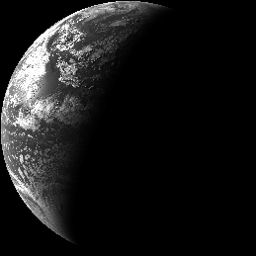

/groups/dthain/users/mislam5/flo-group-base-dir/floability_instance_r-dconv-nd-cold-1_20260209_031840_389344/current_conda_env/lib/python3.14/site-packages/PIL/Image.py:3451: DecompressionBombWarning: Image size (117679104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


after:


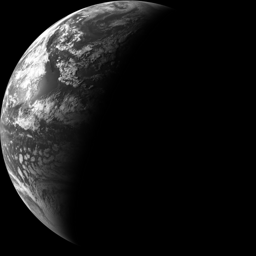

In [26]:
from IPython.display import display
from PIL import Image
import numpy as np

THUMB_MAX = 256  # thumbnail size (long edge)

# pick first file only
nc_path = nc_files[0]
out_path = OUT_DIR / f"{nc_path.stem}_{SELECT_KERNEL}.png"

print("file:", nc_path.name)

# ---- BEFORE: lightweight preview from radiance -------------------
img = load_goes_radiance_2d(nc_path)

stride = max(1, min(img.shape) // THUMB_MAX)
preview_in = img[::stride, ::stride]

preview_in_u8 = to_uint8_for_png(preview_in, PCT_LOW, PCT_HIGH)
img_in = Image.fromarray(preview_in_u8)
img_in.thumbnail((THUMB_MAX, THUMB_MAX))

print("before:")
display(img_in)

# ---- AFTER: thumbnail from output PNG ----------------------------
if out_path.exists():
    with Image.open(out_path) as img_out:
        img_out_thumb = img_out.copy()
        img_out_thumb.thumbnail((THUMB_MAX, THUMB_MAX))

    print("after:")
    display(img_out_thumb)
else:
    print("after: output not found")

In [19]:
from datetime import datetime
from zoneinfo import ZoneInfo
import uuid

now = datetime.now(ZoneInfo("America/New_York")).strftime("%Y-%m-%d %I:%M:%S %p")
exec_id = uuid.uuid4().hex[:8]

print(f"__floability_execution_done__::{now}::{exec_id}")

__floability_execution_done__::2026-02-08 08:25:16 PM::e21bf4d9
